# Telco Customer Churn - Model Training

Prepare the dataset Telco Customer Churn in order to research and training the best model for predicting customer churn.

# Setup Notebook

## Import

In [1]:
# Import Standard Libraries
import pandas as pd
import mlflow
import numpy as np

import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from colorama import Style, Fore

from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve

from xgboost import XGBClassifier

# Import Package Modules
from src.general_utils.general_utils import read_configuration
from src.data_preparation.data_preparation import CustomerChurnDataPreparation
from src.model_training.model_training import ModelTrainer

## Setup Plots Characteristics

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

## Define Configuration

In [4]:
# Retrieve root path
root_path = Path(os.getcwd()).parents[0]

# Read configuration variables
config = read_configuration(root_path / 'configuration' / 'config.yaml')

# Extract configuration variables
dataset_config = config['dataset']
data_pipeline_config = config['data_pipeline_config']
model_training_config = config['model_training_config']

[05/28/2024 15:42:25 - general_utils] INFO - read_configuration - Start
[05/28/2024 15:42:25 - general_utils] INFO - read_configuration - Reading /Users/s.porreca/Projects/customer_churn_predictor/configuration/config.yaml
[05/28/2024 15:42:25 - general_utils] INFO - read_configuration - Configuration file /Users/s.porreca/Projects/customer_churn_predictor/configuration/config.yaml read successfully
[05/28/2024 15:42:25 - general_utils] INFO - read_configuration - End


# Read Data

In [5]:
# Read data
data = pd.read_csv(root_path.as_posix() + '/' + dataset_config['path'])

# Data Preparation

## Define Features and Label

In [6]:
# Define the features to include
features = data_pipeline_config['features']['numerical'] + \
           data_pipeline_config['features']['categorical']

# Define the label to include
label = data_pipeline_config['labels']

print('Features:')
[print(f'{index + 1}. {feature}') for index, feature in enumerate(features)]
print()
print(f'Labels: {label}')

Features:
1. tenure
2. MonthlyCharges
3. TotalCharges
4. gender
5. SeniorCitizen
6. Partner
7. Dependents
8. PhoneService
9. MultipleLines
10. InternetService
11. OnlineSecurity
12. OnlineBackup
13. DeviceProtection
14. TechSupport
15. StreamingTV
16. StreamingMovies
17. Contract
18. PaperlessBilling
19. PaymentMethod

Labels: ['Churn']


## Define Data Preparation Pipeline 

In [7]:
# Instance the data preparation pipeline object
data_preparation = CustomerChurnDataPreparation(data_pipeline_config['data_transformations'], 
                                                data_pipeline_config['features'])

[05/28/2024 15:42:25 - CustomerChurnDataPreparation] INFO - __init__ - Initialise object attributes


In [8]:
# Get the training data preparation pipeline
data_preparation_pipeline = data_preparation.build_training_data_preparation_pipeline()

[05/28/2024 15:42:25 - CustomerChurnDataPreparation] INFO - build_training_data_preparation_pipeline - Start
[05/28/2024 15:42:25 - CustomerChurnDataPreparation] INFO - build_training_data_preparation_pipeline - Build the Numerical Data Pipeline
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Start
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Building steps
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Skipping Feature Engineering step
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Adding SimpleImputer Imputation step
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Adding MinMaxScaler Standardisation step
[05/28/2024 15:42:25 - data_preparation_utils] INFO - build_numerical_data_pipeline_steps - Skipping Normalization step
[05/28/2024 15:42:25 - data_preparation_u

In [9]:
data_preparation_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputation',
                                                  SimpleImputer(copy=False,
                                                                strategy='median')),
                                                 ('standardisation',
                                                  MinMaxScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('imputation',
                                                  SimpleImputer(copy=False,
                                                                fill_value='unknown',
                                                                strategy='constant')),
                                                 ('one_hot_encoding',
                                                  OneHotEncoder())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

## Clean TotalCharges

`TotalCharges` has white space values for new customers → Replace white spaces with 0 and cast the column to float

In [10]:
# Replace spaces with 0
data['TotalCharges'] = data['TotalCharges'].replace(' ', '0')

In [11]:
# Convert the column to float
data['TotalCharges'] = data['TotalCharges'].astype(float)

## Label Encoder

In [12]:
# Encode the label
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(np.ravel(data[label]))

## Train & Test Split

In [13]:
# Define X and y for the training set
X = data[features]
y = encoded_labels

In [14]:
# Retrieve test_size and random_state
test_size = data_pipeline_config['train_test_split']['test_size']
random_state = data_pipeline_config['train_test_split']['random_state']

In [15]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    random_state=random_state)

# Model Training

## Setup Training

In [16]:
# Set MLflow Experiment
mlflow_experiment_name = model_training_config['mlflow']['experiment_name']

# Set MLflow Experiment
mlflow.set_experiment(mlflow_experiment_name)

<Experiment: artifact_location='file:///Users/s.porreca/Projects/customer_churn_predictor/notebooks/mlruns/887185653513794297', creation_time=1716888584313, experiment_id='887185653513794297', last_update_time=1716888584313, lifecycle_stage='active', name='Version 1.0.3', tags={}>

In [17]:
# Initialise trained models dictionary
models = {}

# Initialize DataFrame of models performance
performance = pd.DataFrame(columns=model_training_config['metrics'])

## Logistic Regression

In [18]:
# Define the model
model_lr = LogisticRegression()

# Create a ModelTrainer
model_trainer_lr = ModelTrainer(model_name=model_training_config['logistic_regression']['model_name'], 
                                model=model_lr, 
                                data_pipeline=data_preparation_pipeline)

[05/28/2024 15:42:26 - ModelTrainer] INFO - __init__ - Initialise object attributes


In [19]:
# Start an MLflow run
with mlflow.start_run(run_name=model_training_config['logistic_regression']['mlflow_run_name']):
    
    print(f'MLflow Run ID: {mlflow.active_run().info.run_id}\n')

    # Fit the model trainer
    model_trainer_lr.bundle_and_fit_pipeline(X_train, y_train)
    
    # Evaluate the model trainer
    evaluation = model_trainer_lr.evaluate_pipeline(X_test, y_test, model_training_config['metrics'])
    
    # Log model's evaluation metrics
    mlflow.log_metrics(evaluation.to_dict()['Value'])
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Label': label,
                       'Data Transformations': data_pipeline_config['data_transformations'],
                       'Model Initial Hyperparameters': None,
                       'Model Optimised Hyperparameters': None})
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_trainer_lr.pipeline,
        artifact_path='model_artifacts',
        registered_model_name=model_training_config['logistic_regression']['mlflow_run_name']
    )

MLflow Run ID: c02e5a8508c94a21bf5296cd97829e47

[05/28/2024 15:42:26 - ModelTrainer] INFO - bundle_and_fit_pipeline - Start
[05/28/2024 15:42:26 - ModelTrainer] INFO - bundle_and_fit_pipeline - Bundle the pipeline
[05/28/2024 15:42:26 - ModelTrainer] INFO - bundle_and_fit_pipeline - Fit the pipeline
[05/28/2024 15:42:26 - ModelTrainer] INFO - bundle_and_fit_pipeline - End
[05/28/2024 15:42:26 - ModelTrainer] INFO - evaluate_pipeline - Start
[05/28/2024 15:42:26 - ModelTrainer] INFO - evaluate_pipeline - Compute predictions
[05/28/2024 15:42:26 - ModelTrainer] INFO - evaluate_pipeline - Evaluate pipeline
[05/28/2024 15:42:26 - model_training_utils] INFO - compute_classification_metrics - Start
[05/28/2024 15:42:26 - model_training_utils] INFO - compute_classification_metrics - Computed metrics
[05/28/2024 15:42:26 - model_training_utils] INFO -            Value
Accuracy    0.79
Precision   0.64
Recall      0.51
F1 Score    0.57
ROC AUC     0.83
[05/28/2024 15:42:26 - model_training_uti

Successfully registered model 'Logistic Regression'.
Created version '1' of model 'Logistic Regression'.


In [20]:
# Update performance dataframe for Model Explainability
performance.loc[model_training_config['logistic_regression']['mlflow_run_name']] = evaluation.Value.values

# Update models dataframe for Model Explainability
models[model_training_config['logistic_regression']['model_name']] = model_trainer_lr.pipeline

## XGBoost Classifier

In [21]:
# Define the model
model_xgb = XGBClassifier(**model_training_config['xgboost']['parameters'])

# Create a ModelTrainer
model_trainer_xgb = ModelTrainer(model_name=model_training_config['xgboost']['model_name'],
                                 model=model_xgb,
                                 data_pipeline=data_preparation_pipeline)

[05/28/2024 15:42:29 - ModelTrainer] INFO - __init__ - Initialise object attributes


In [22]:
# Start an MLflow run
with mlflow.start_run(run_name=model_training_config['xgboost']['mlflow_run_name']):
    
    print(f'MLflow Run ID: {mlflow.active_run().info.run_id}\n')

    # Fit the model trainer
    model_trainer_xgb.bundle_and_fit_pipeline(X_train, y_train)
    
    # Evaluate the model trainer
    evaluation = model_trainer_xgb.evaluate_pipeline(X_test, y_test, model_training_config['metrics'])
    
    # Log model's evaluation metrics
    mlflow.log_metrics(evaluation.to_dict()['Value'])
    
    # Log model's features
    mlflow.log_params({'Features': features, 
                       'Label': label,
                       'Data Transformations': data_pipeline_config['data_transformations'],
                       'Model Initial Hyperparameters': model_trainer_xgb.model.get_params(),
                       'Model Optimised Hyperparameters': None})
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_trainer_lr.pipeline,
        artifact_path='model_artifacts',
        registered_model_name=model_training_config['xgboost']['mlflow_run_name']
    )

MLflow Run ID: 0963be83f1e84296a4e7570d97ed2785

[05/28/2024 15:42:29 - ModelTrainer] INFO - bundle_and_fit_pipeline - Start
[05/28/2024 15:42:29 - ModelTrainer] INFO - bundle_and_fit_pipeline - Bundle the pipeline
[05/28/2024 15:42:29 - ModelTrainer] INFO - bundle_and_fit_pipeline - Fit the pipeline
[05/28/2024 15:42:29 - ModelTrainer] INFO - bundle_and_fit_pipeline - End
[05/28/2024 15:42:29 - ModelTrainer] INFO - evaluate_pipeline - Start
[05/28/2024 15:42:29 - ModelTrainer] INFO - evaluate_pipeline - Compute predictions
[05/28/2024 15:42:29 - ModelTrainer] INFO - evaluate_pipeline - Evaluate pipeline
[05/28/2024 15:42:29 - model_training_utils] INFO - compute_classification_metrics - Start
[05/28/2024 15:42:30 - model_training_utils] INFO - compute_classification_metrics - Computed metrics
[05/28/2024 15:42:30 - model_training_utils] INFO -            Value
Accuracy    0.79
Precision   0.66
Recall      0.50
F1 Score    0.57
ROC AUC     0.83
[05/28/2024 15:42:30 - model_training_uti

Successfully registered model 'XGBoost'.
Created version '1' of model 'XGBoost'.


In [23]:
# Update performance dataframe for Model Explainability
performance.loc[model_training_config['xgboost']['mlflow_run_name']] = evaluation.Value.values

# Update models dataframe for Model Explainability
models[model_training_config['xgboost']['model_name']] = model_trainer_xgb.pipeline

# Model Explainability

## Model Comparison

As we want to minimise the amount of False Negative, it is better to set as North Star metric the **Recall**.

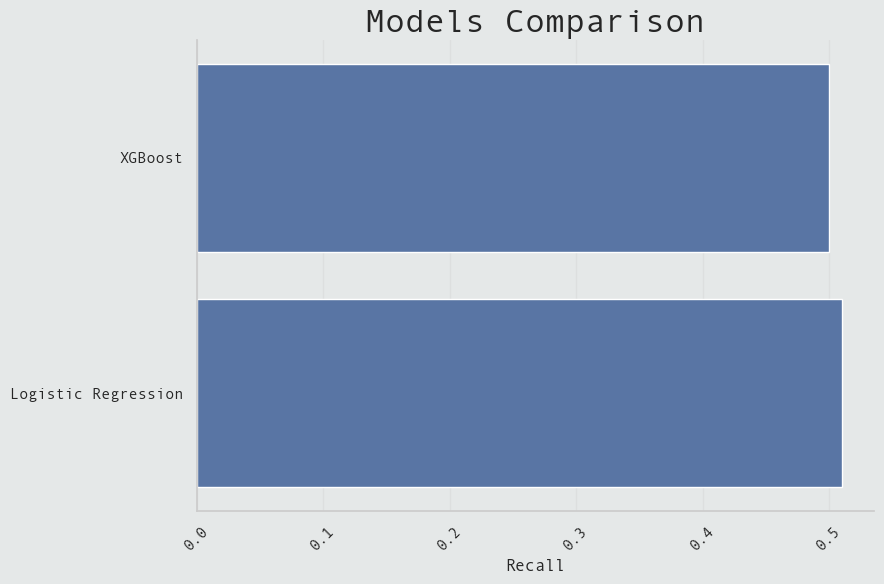

In [24]:
# Sort dataframe by the metric
performance.sort_values('Recall', inplace=True)

# Create figure
figure = plt.figure(tight_layout=True, figsize=(9, 6))

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x='Recall', 
                 y=performance.index.tolist())

# Set title
ax.set_title('Models Comparison', 
             fontsize=24)

# Set tick rotation
plt.xticks(rotation=45)

# Plot with tight layout
plt.tight_layout()

- There is not much difference in terms of North Star metric

## Confusion Matrix

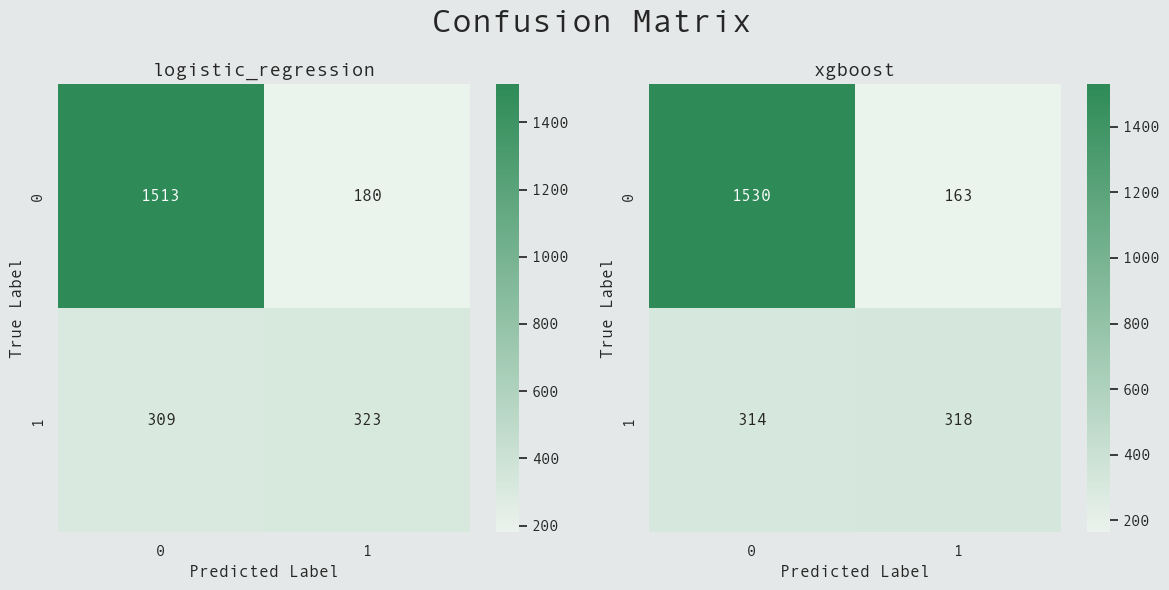

In [25]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Compute confusion matrix
    test_data_confusion_matrix = confusion_matrix(y_test, predictions)
    
    # Plot confusion matrix
    sns.heatmap(test_data_confusion_matrix,
                annot=True,
                cmap=sns.light_palette("seagreen", as_cmap=True),
                fmt='g',
                ax=ax[index])
    
    # Set y label
    ax[index].set_ylabel('True Label',
                         fontweight='bold')

    # Set x label
    ax[index].set_xlabel('Predicted Label',
                         fontweight='bold')
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Confusion Matrix',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

- Also from a Confusion Matrix perspective, they look the same

## Precision-Recall Curve

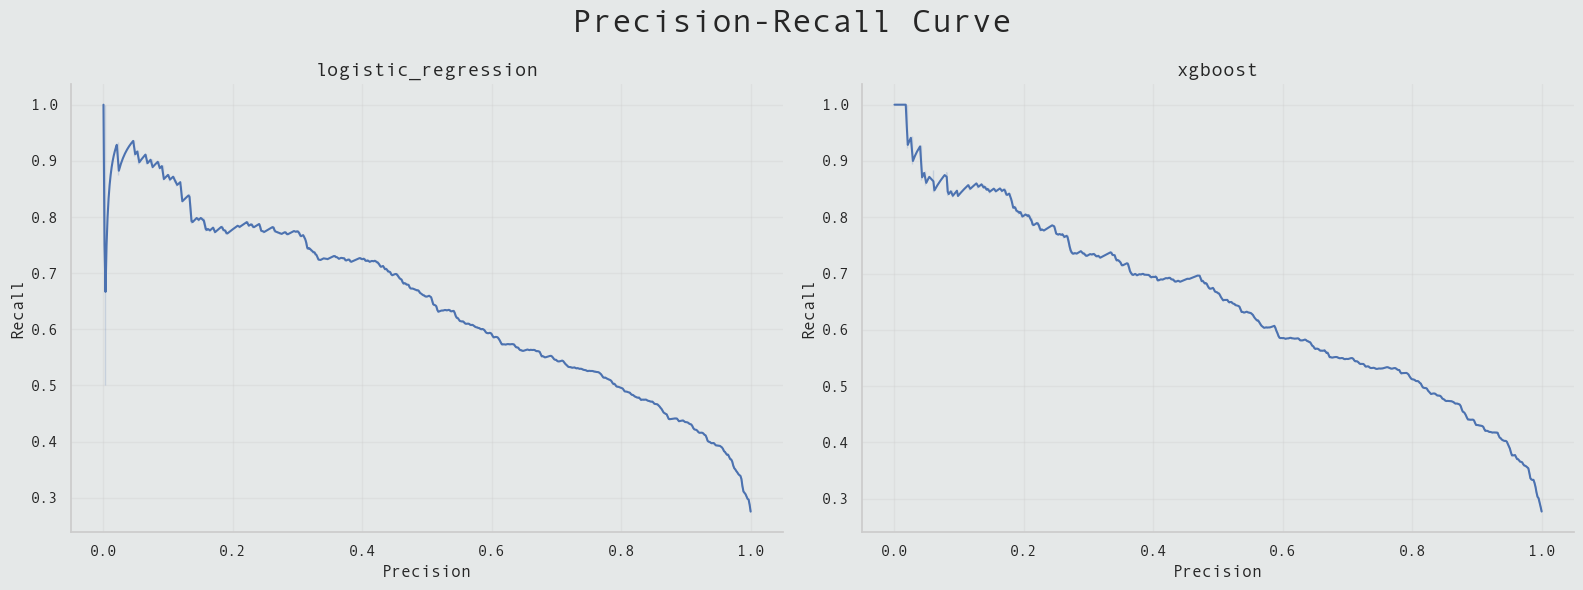

In [26]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Compute the predictions for the test set
    probabilities = models[model_name].predict_proba(X_test)[:, 1]
    
    # Calculate precision, recall, and thresholds
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    
    # Plot the Precision-Recall curve
    sns.lineplot(data=pd.DataFrame({'Precision': precision, 'Recall': recall}), 
                 x='Recall', 
                 y='Precision', 
                 ax=ax[index])
    
    # Set y label
    ax[index].set_ylabel('Recall',
                         fontweight='bold')

    # Set x label
    ax[index].set_xlabel('Precision',
                         fontweight='bold')
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Precision-Recall Curve',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

- Same Precision-Recall curve

## Feature Importance

/var/folders/2t/wgg9ryl91kxd7b51f7g035jsdh30gy/T/ipykernel_8926/876989153.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[index].set_xticklabels(feature_importance_df['Feature'],
/var/folders/2t/wgg9ryl91kxd7b51f7g035jsdh30gy/T/ipykernel_8926/876989153.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[index].set_xticklabels(feature_importance_df['Feature'],


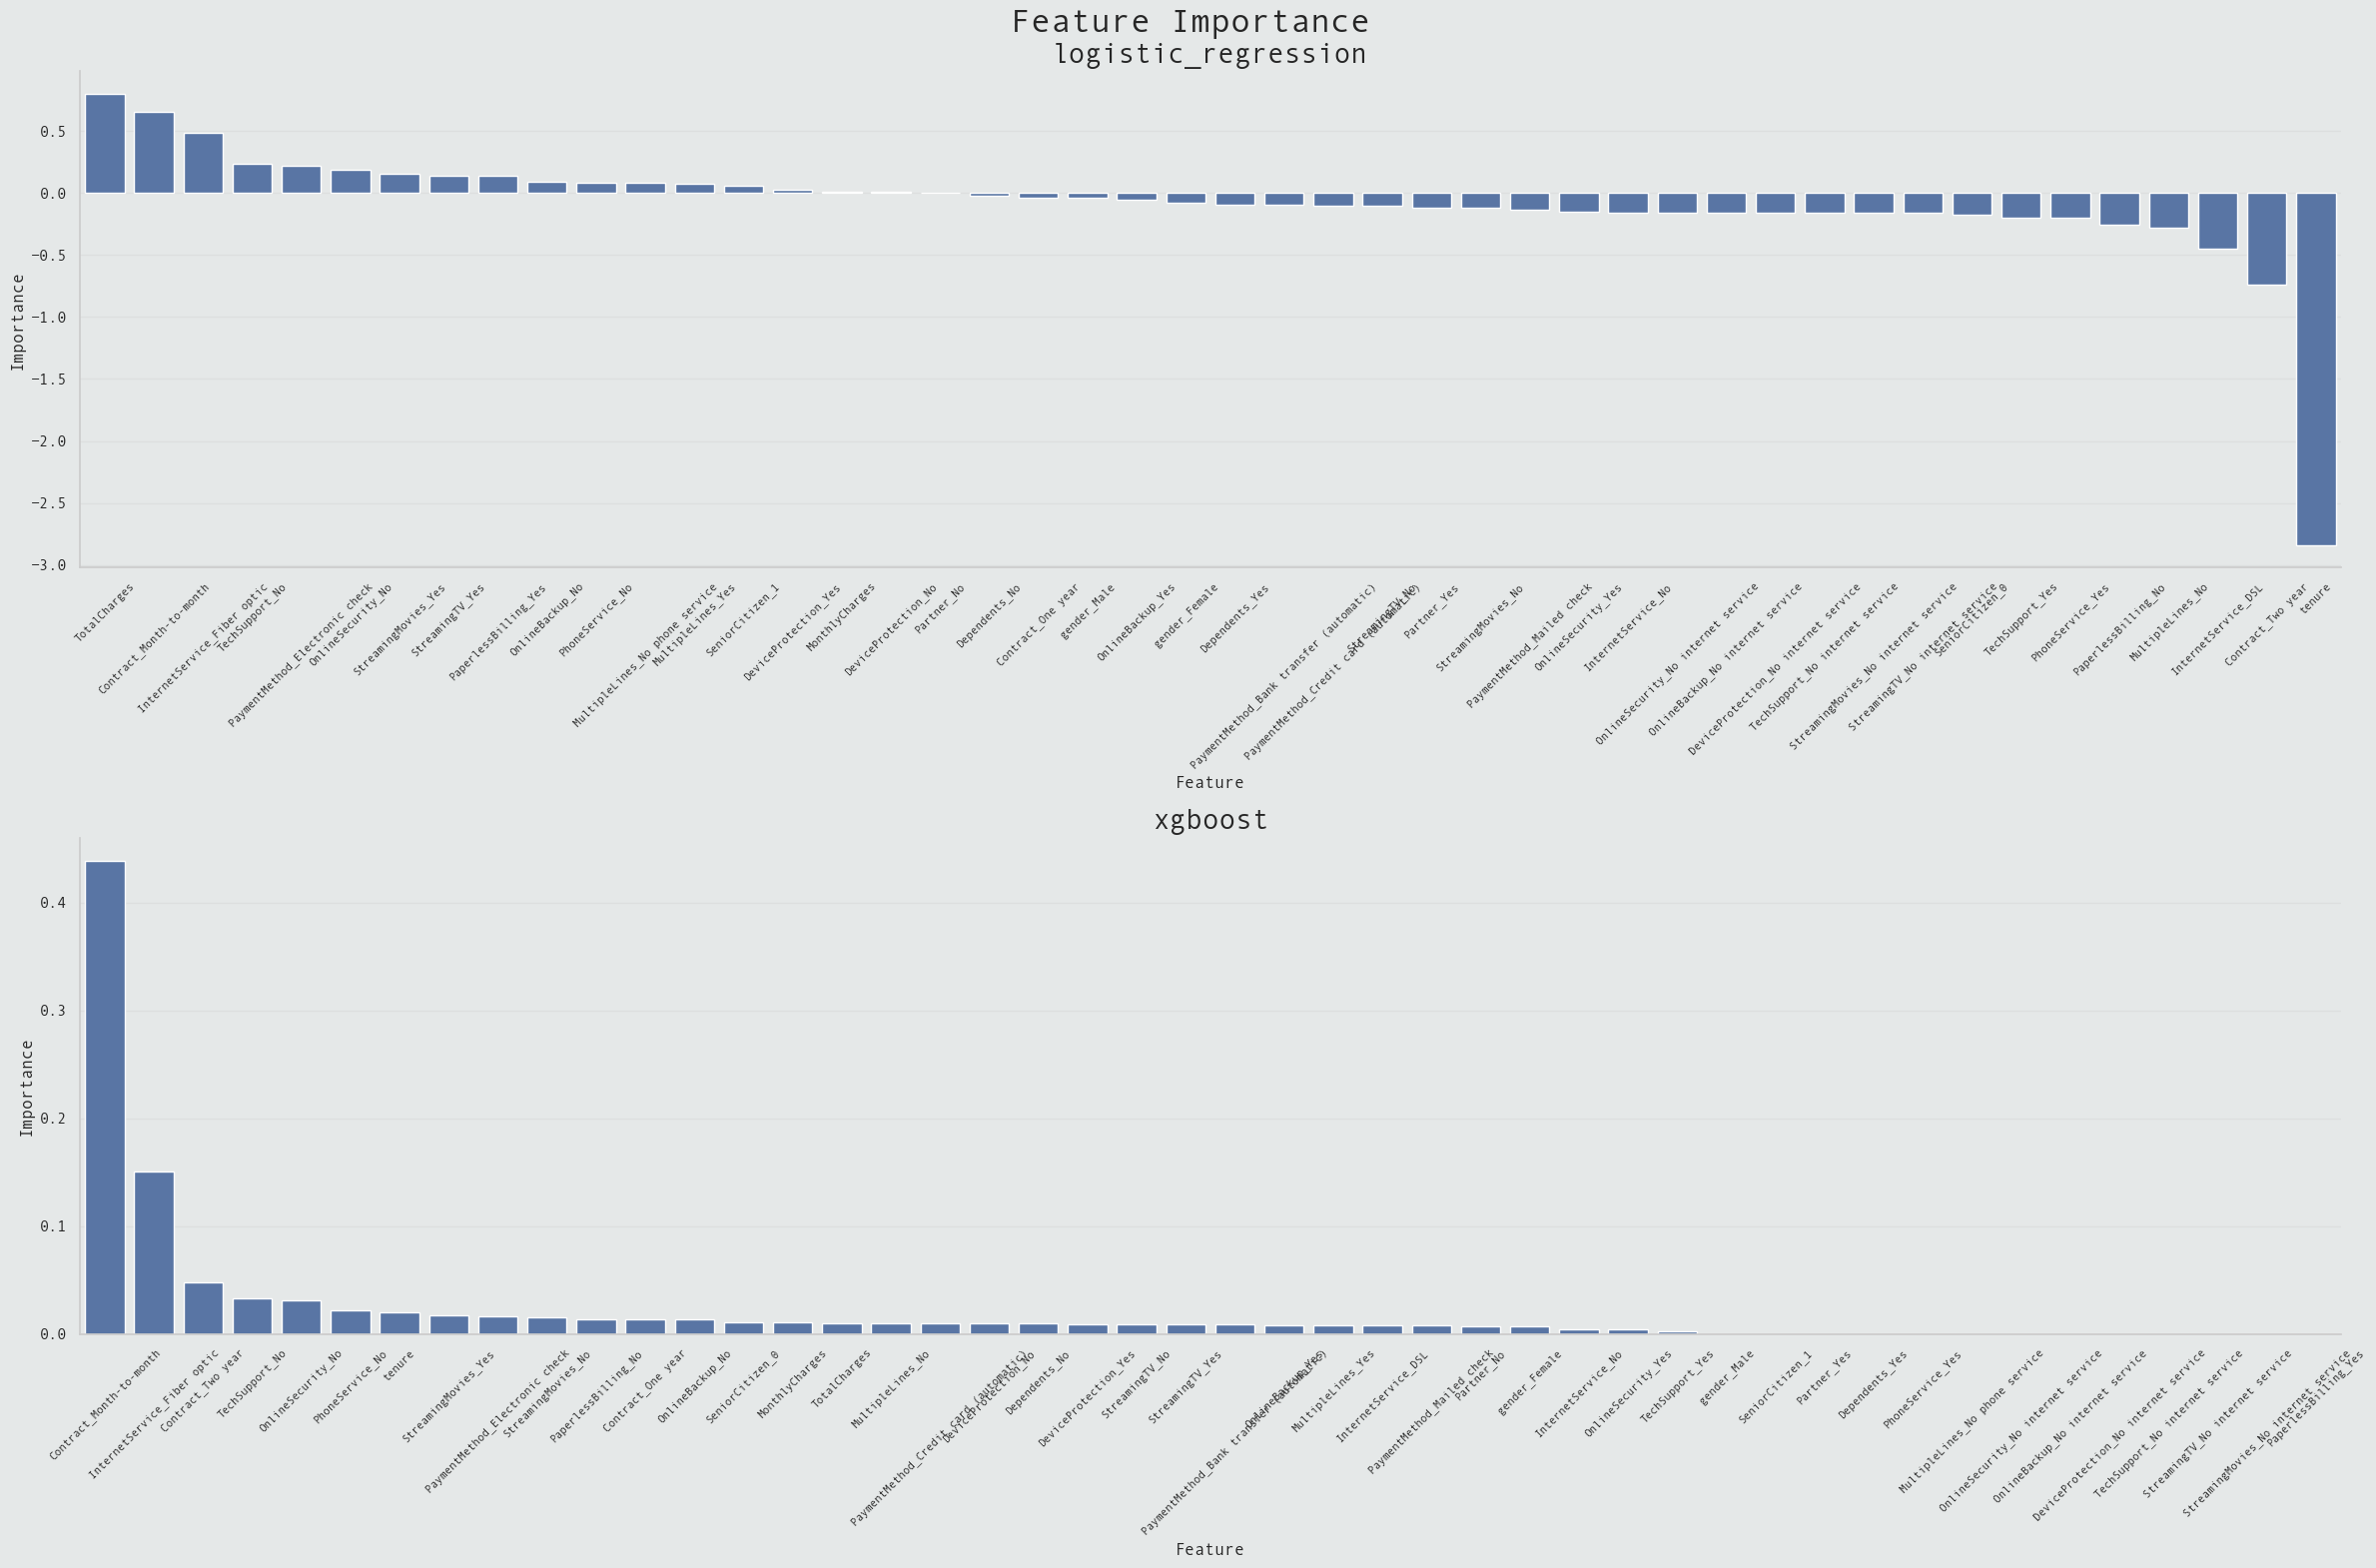

In [27]:
# Define figure and axes
figure, ax = plt.subplots(2, 1, figsize=(24, 16))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Retrieve feature names
    feature_names = models[model_name].named_steps['data_preprocessing'].get_feature_names_out()
    
    # Refactor feature names to remove the ColumnTransformer prefix
    feature_names = [feature_name.split('__')[-1] for feature_name in feature_names]
    
    # Retrieve pipeline model's step name
    pipe_model_step_name = list(models[model_name].named_steps.keys())[-1]
    
    # Retrieve feature importance values
    try:
        # Tree-based models
        feature_importance_values = models[model_name].named_steps[pipe_model_step_name].feature_importances_
    except:
        # Regression-based models
        feature_importance_values = models[model_name].named_steps[pipe_model_step_name].coef_.reshape(-1,)
        
    
    
    # Compute the feature importance
    feature_importance = sorted(list(zip(feature_names,
                                         feature_importance_values)),
                                key=lambda x: x[1], reverse=True)

    # Transform it into a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance,
                                         columns= ['Feature', 'Importance'])    
    
    # Plot the feature importance
    sns.barplot(data=feature_importance_df,
               x='Feature',
               y='Importance', 
               ax=ax[index])

    # Set title
    ax[index].set_title(model_name, 
                 fontsize=20)

    # Refine x labels
    ax[index].set_xticklabels(feature_importance_df['Feature'],
                              fontsize=8,
                              rotation=45)

# Define figure title
figure.suptitle('Feature Importance',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- Difference in the feature importance values might be related in the feature splitting approach of an ensamble method, such as XGBoost

## Learning Curves

In [28]:
# Define Learning Curves Display parameters
learning_curves_display_parameters = {
    'X': X,
    'y': y,
    'cv': ShuffleSplit(n_splits=3, test_size=0.3, random_state=108),
    'train_sizes': np.linspace(0.1, 1.0, 8),
    'scoring': 'neg_root_mean_squared_error',
    'negate_score': True,
    'score_name': 'RMSE',
    'score_type': 'both',
    'verbose': 0,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
}

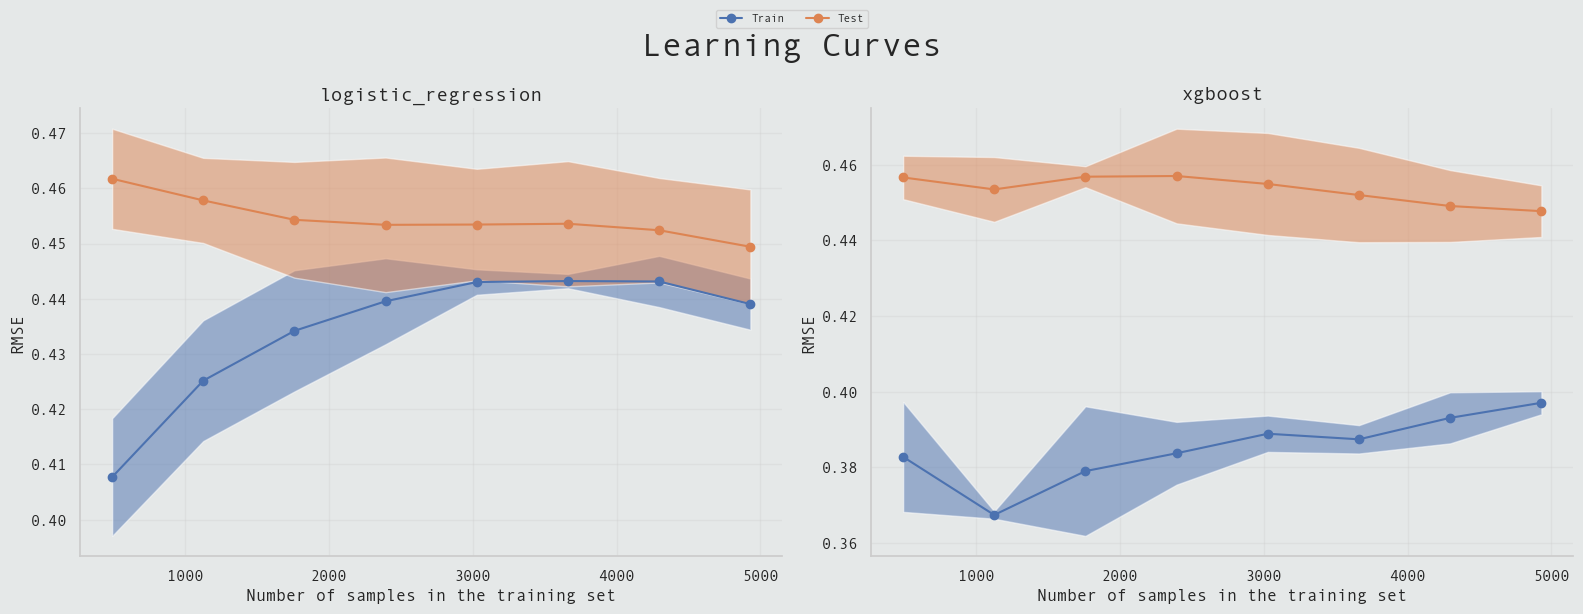

In [29]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Plot the Learning Curve
    LearningCurveDisplay.from_estimator(models[model_name], 
                                        **learning_curves_display_parameters,
                                        ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=8,
              ncol=2)

# Define figure title
figure.suptitle('Learning Curves',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

- Here is the main difference: while the Logistic Regression can not learn anymore from the data, the XGBoost has still learning potential. This can be deducted by looking at how the curves are converging for the XGBoost plot.